In [2]:
import numpy as np
import matplotlib.pyplot as plt   
from scipy import stats
import os
import random
import pandas as pd
import re
from tvb.simulator.lab import *
import nibabel as nib

Measures=pd.read_csv('Measures_2ndbatch.csv')

/home/etienne/env/src/tvb-library/scientific_library/tvb/datatypes/surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [3]:
# Import the anatomical structural connectivity.
pathc='/home/etienne/data/connectivity/'
A148_con = connectivity.Connectivity.from_file(pathc+'Allen_148.zip')
nregions = len(A148_con.weights)     #number of regions
A148_con.speed = np.asarray(np.inf)  #set the conduction speed
np.fill_diagonal(A148_con.weights, 0.)
A148_con.weights = A148_con.weights/np.max(A148_con.weights) #normalization
A148_con.configure()
A148_SC = A148_con.weights

file_refs= nib.load(pathc + 'Vol_148_Allen.nii')

A148= file_refs.get_fdata() 

# ROIs Labels 
with open(pathc+'region_labels.txt') as f:
    content = f.readlines()   # remove whitespace characters like `\n` at the end of each line
ROIs = [ix.strip() for ix in content] 

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


In [4]:
A148_con.weights

array([[0.00000000e+00, 7.76383445e-02, 2.51024758e-02, ...,
        8.22420459e-05, 1.68041681e-04, 3.82396312e-06],
       [1.45261583e-01, 0.00000000e+00, 1.55072991e-01, ...,
        3.67619300e-04, 8.44289968e-05, 2.84406819e-04],
       [6.09168026e-02, 8.71871177e-02, 0.00000000e+00, ...,
        1.48531847e-05, 1.70333290e-05, 1.18821286e-10],
       ...,
       [0.00000000e+00, 1.45548060e-05, 2.20358578e-05, ...,
        0.00000000e+00, 1.76152489e-05, 1.37307264e-02],
       [7.76934271e-05, 1.34879511e-04, 1.09834805e-04, ...,
        4.52674721e-03, 0.00000000e+00, 4.32628962e-04],
       [1.88054765e-06, 6.36174109e-05, 1.60080207e-04, ...,
        1.07004302e-02, 6.65357107e-02, 0.00000000e+00]])

In [5]:
regions=pd.read_csv('modules.csv')
Modules = {'DMN':[
'Right Temporal association areas',#TeA
'Left Temporal association areas',#TeA
'Right Retrosplenial area, lateral agranular part',#Rs
'Right Retrosplenial area, dorsal part',#Rs
'Right Retrosplenial area, ventral part',#Rs
'Left Retrosplenial area, lateral agranular part',#Rs
'Left Retrosplenial area, dorsal part',#Rs
'Left Retrosplenial area, ventral part',#Rs
'Right Anterior cingulate area, dorsal part',#Cg
'Right Anterior cingulate area, ventral part',#Cg
'Left Anterior cingulate area, dorsal part',#Cg
'Left Anterior cingulate area, ventral part',#Cg
'Right Orbital area, lateral part',#OFc
'Right Orbital area, medial part',#OFc
'Left Orbital area, lateral part',#OFc
'Left Orbital area, medial part',#OFc
'Right Primary auditory area',#seemed nice
'Left Primary auditory area',#seemed nice
'Right Anterolateral visual area',#seemed nice
'Left Anterolateral visual area',#seemed nice
'Right Anteromedial visual area',#seemed nice
'Left Anteromedial visual area',#seemed nice
'Right Lateral visual area',#seemed nice
'Left Lateral visual area',#seemed nice
'Right Primary visual area',#seemed nice
'Left Primary visual area',#seemed nice
'Right posteromedial visual area',#seemed nice
'Left posteromedial visual area',#seemed nice
'Right Ectorhinal area',#seemed nice
'Left Ectorhinal area',#seemed nice
],
     'LCN':[
'Right Primary somatosensory area, nose',#S1
'Right Primary somatosensory area, barrel field',#S1
'Right Primary somatosensory area, lower limb',#S1
'Right Primary somatosensory area, mouth',#S1
'Right Primary somatosensory area, upper limb',#S1
'Right Primary somatosensory area, trunk',#S1
'Right Supplemental somatosensory area',#S2
'Left Primary somatosensory area, nose',#S1
'Left Primary somatosensory area, barrel field',#S1
'Left Primary somatosensory area, lower limb',#S1
'Left Primary somatosensory area, mouth',#S1
'Left Primary somatosensory area, upper limb',#S1
'Left Primary somatosensory area, trunk',#S1
'Left Supplemental somatosensory area',#S2
'Right Primary motor area',#M1
'Left Primary motor area',#M1
'Right Agranular insular area, dorsal part',#seemed nice
'Right Agranular insular area, posterior part',#seemed nice
'Left Agranular insular area, dorsal part',#seemed nice
'Left Agranular insular area, posterior part',#seemed nice
 ],
           
    'Hc':[
'Right Field CA1',#Hc
'Right Field CA3',#Hc
'Right Dentate gyrus',#Hc
'Right Parasubiculum',#Hc
'Right Subiculum',#Hc
'Left Field CA1',#Hc
'Left Field CA3',#Hc
'Left Dentate gyrus',#Hc
'Left Parasubiculum',#Hc
'Left Subiculum',#Hc
'Right Anterior pretectal nucleus',#Hc
'Left Anterior pretectal nucleus',#Hc
'Right Medial geniculate complex',#seemed nice
'Left Medial geniculate complex',#seemed nice
'Right Dorsal part of the lateral geniculate complex',#seemed nice
'Left Dorsal part of the lateral geniculate complex',#seemed nice
'Right Superior colliculus, motor related',
'Left Superior colliculus, motor related',
'Right Midbrain reticular nucleus',#seemed nice
'Left Midbrain reticular nucleus',#seemed nice
'Right Lateral posterior nucleus of the thalamus',#Lateral Dorsal Th
'Left Lateral posterior nucleus of the thalamus',#Lateral Dorsal Th
'Right Mediodorsal nucleus of thalamus',
'Left Mediodorsal nucleus of thalamus',#Th

],
    'BF':[
'Right Nucleus accumbens',#Acb
'Left Nucleus accumbens',#Acb
'Right Anterior olfactory nucleus',#AO
'Left Anterior olfactory nucleus',#AO
'Right Lateral septal nucleus, rostral (rostroventral) part', #seemed nice
'Left Lateral septal nucleus, rostral (rostroventral) part', #seemed nice
'Right Substantia innominata',#seemed nice
'Left Substantia innominata',#seemed nice
],
    'VM':[
'Right Anterior hypothalamic nucleus',#Hypo
'Right Lateral hypothalamic area',#Hypo
'Left Anterior hypothalamic nucleus',#Hypo
'Left Lateral hypothalamic area',#Hypo
'Right Cortical amygdalar area, posterior part',#Amy
'Right Lateral amygdalar nucleus',#Amy
'Right Basolateral amygdalar nucleus',#Amy
'Right Basomedial amygdalar nucleus',#Amy
'Left Cortical amygdalar area, posterior part',#Amy
'Left Lateral amygdalar nucleus',#Amy
'Left Basolateral amygdalar nucleus',#Amy
'Left Basomedial amygdalar nucleus',#Amy
'Right Entorhinal area, lateral part',#Hc
'Left Entorhinal area, lateral part',#Hc
'Right Postpiriform transition area',#seemed nice
'Left Postpiriform transition area',#seemed nice
'Right Endopiriform nucleus, dorsal part',#seemed nice
'Left Endopiriform nucleus, dorsal part',#seemed nice
],
    'Th':[
'Right Ventral anterior-lateral complex of the thalamus',#Ventral Dorsal Th
'Right Ventral medial nucleus of the thalamus',#Ventral Dorsal Th
'Right Posterior complex of the thalamus',#Lateral Dorsal Th
'Right Lateral dorsal nucleus of thalamus',#Lateral Dorsal Th
'Left Ventral anterior-lateral complex of the thalamus',#Ventral Dorsal Th
'Left Ventral medial nucleus of the thalamus',#Ventral Dorsal Th
'Left Posterior complex of the thalamus',#Lateral Dorsal Th
'Left Lateral dorsal nucleus of thalamus',#Lateral Dorsal Th
'Right Reticular nucleus of the thalamus',#Th
'Left Reticular nucleus of the thalamus',#Th

],
    'Other':[
'Right Frontal pole, cerebral cortex', 
'Right Infralimbic area',
'Right Caudoputamen', 
'Right Inferior colliculus',
'Right Ventral cochlear nucleus',
'Right Nucleus of the solitary tract',
'Right Spinal nucleus of the trigeminal, caudal part',
'Right Intermediate reticular nucleus',
'Right Medullary reticular nucleus',
'Right Medial vestibular nucleus', 
'Right Central lobule',
'Right Culmen', 
'Right Folium-tuber vermis (VII)',
'Right Ansiform lobule', 
'Right Paramedian lobule',
'Right Interposed nucleus', 
'Left Frontal pole, cerebral cortex',
'Left Infralimbic area',
'Left Caudoputamen',
'Left Inferior colliculus', 
'Left Ventral cochlear nucleus',
'Left Nucleus of the solitary tract',
'Left Spinal nucleus of the trigeminal, caudal part',
'Left Intermediate reticular nucleus',
'Left Medullary reticular nucleus',
'Left Medial vestibular nucleus', 
'Left Central lobule',
'Left Culmen', 
'Left Folium-tuber vermis (VII)',
'Left Ansiform lobule', 
'Left Paramedian lobule',
'Left Interposed nucleus',
'Right Paraflocculus',
'Left Paraflocculus',
'Right Principal sensory nucleus of the trigeminal',
'Left Principal sensory nucleus of the trigeminal',
'Right Pontine reticular nucleus',
'Left Pontine reticular nucleus',
]
}

FHubs={'vSub':[
''    
],
    'AON':[
'Right Anterior olfactory nucleus',#AO
'Left Anterior olfactory nucleus',#AO
],
    'Cg':[
'Right Anterior cingulate area, dorsal part',#Cg
'Right Anterior cingulate area, ventral part',#Cg
'Left Anterior cingulate area, dorsal part',#Cg
'Left Anterior cingulate area, ventral part',#Cg
],
    'Hc':[
]
}

In [6]:
def go_edge(tseries):
    nregions=tseries.shape[1]
    Blen=tseries.shape[0]
    nedges=int(nregions**2/2-nregions/2)
    iTriup= np.triu_indices(nregions,k=1) 
    gz=stats.zscore(tseries,nan_policy='omit')
    Eseries = gz[:,iTriup[0]]*gz[:,iTriup[1]]
    return Eseries

def edges_str(Bold):
    return(np.sqrt(np.sum(go_edge(Bold)**2,axis=1)))

def Giom_mean(Bold):
    a=edges_str(Bold)
    G=go_edge(Bold)
    Blen=len(a)
    top=G[a>np.percentile(a,95),:]
    dFC=np.corrcoef(top)
    return(np.mean(dFC))
    #return(np.sum(np.abs(a[1:]-a[:Blen-1]))/Blen)

def edges_var(Bold):
    a=edges_str(Bold)
    Blen=len(a)
    return(np.sum(np.abs(a[1:]-a[:Blen-1]))/Blen)    


In [7]:
def functional_hub(Bold,nregions=5):
    #Return the nregions regions having the biggest participation in the 3 biggest eigenvectors (moduled by the eigenvalues)
    #The regions are sorted in a decreasing importance 
    
    FC=np.corrcoef(Bold.T)
    if np.isnan(FC).any():
        M=np.zeros(nregions)
        M[:]=np.nan
        return(M)
    D,E=np.linalg.eig(FC)
    order=np.argsort(np.sum(np.abs(E[:,:3])*D[:3],axis=1))
    return(np.flip(order[-nregions:]))

def common_hubs(B1,B2,n=8):
    hub1=functional_hub(B1,nregions=n)
    hub2=functional_hub(B2,nregions=n)
    return(np.intersect1d(hub1,hub2))

def predictive_power(B1,B2):
    FC1=np.corrcoef(B1.T)
    FC2=np.corrcoef(B2.T)
    T1=FC1[np.triu_indices(FC1.shape[0],k=1)]
    T2=FC2[np.triu_indices(FC2.shape[0],k=1)]
    if np.isnan([FC1,FC2]).any():
        return([0,0])
    return(stats.pearsonr(T1,T2))

def best_PP(Bold,Bsim):
    m=Bsim.shape[2]
    M=np.zeros(m)
    for k in range(m):
        M[k]=predictive_power(Bold,Bsim[:,:,k])[0]
    return(np.argwhere(M == np.amax(M)),np.amax(M))

In [8]:
path='/home/etienne/data/simulation_second_batch/'
path2='/home/etienne/data/dataXetien/'

remove_roi=[55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
            129, 130,  131,  132,  133,  134,  135,  136,  137,  138,  139,  140, 141, 142, 143,144,145,146,147, 27, 101]

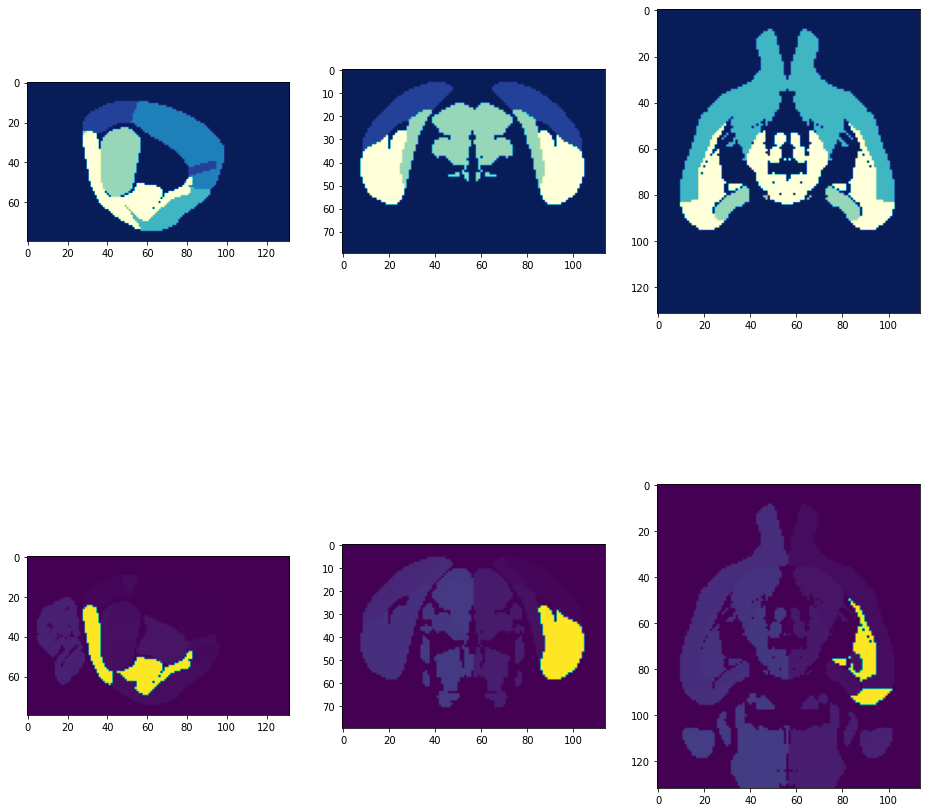

In [9]:
rois=regions
A=regions.iloc[remove_roi,:]

regDMN=rois[rois['regions'].isin(Modules['DMN'])].index.tolist()
regLCN=rois[rois['regions'].isin(Modules['LCN'])].index.tolist()
regBF=rois[rois['regions'].isin(Modules['BF'])].index.tolist()
regHc=rois[rois['regions'].isin(Modules['Hc'])].index.tolist()
regVM=rois[rois['regions'].isin(Modules['VM'])].index.tolist()
regTh=rois[rois['regions'].isin(Modules['Th'])].index.tolist()
regother=rois[rois['regions'].isin(Modules['Other'])].index.tolist()
#the higher cells correspond to the olfactory bulb ('starting' of the brain in a sense), we plot on the plan orthogonal to the longest axe
cutx=35
#the higher cells correspond to the motor cortex ('up' of the brain in a sense), we plot on the plan orthogonal to the shortest axe
cutz=20
cuty=90

region=[37, 38, 26, 33, 36]

A148bis=np.where(np.isin(A148[:,:,:],regDMN),150,A148[:,:,:])
A148ter=np.where(np.isin(A148bis[:,:,:],regLCN),300,A148bis[:,:,:])
A148qua=np.where(np.isin(A148ter[:,:,:],regBF),450,A148ter[:,:,:])
A148cin=np.where(np.isin(A148qua[:,:,:],regHc),600,A148qua[:,:,:])
A148VM=np.where(np.isin(A148cin[:,:,:],regTh),750,A148cin[:,:,:])
A148Th=np.where(np.isin(A148VM[:,:,:],regVM),900,A148VM[:,:,:])
A148oth=np.where(np.isin(A148Th[:,:,:],regother),-1,A148Th[:,:,:])

f, axarr = plt.subplots(2,3,figsize=(16,16))
img1=axarr[0,1].imshow(A148oth[:,cutx,:][:,::-1].T,cmap='YlGnBu_r')
img0=axarr[0,0].imshow(A148oth[cuty,:,:][:,::-1].T,cmap='YlGnBu_r')
img2=axarr[0,2].imshow(A148oth[:,:,cutz][:,::-1].T,cmap='YlGnBu_r')


axarr[1,1].imshow(np.where(np.isin(A148[:,cutx,:],region),800,A148[:,cutx,:])[:,::-1].T)
axarr[1,0].imshow(np.where(np.isin(A148[cuty,:,:],region),800,A148[cuty,:,:])[:,::-1].T)
axarr[1,2].imshow(np.where(np.isin(A148[:,:,cutz],region),800,A148[:,:,cutz])[:,::-1].T)

In [10]:
Blen=2000
nregions=148
file_number=(len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]))
B=np.zeros((Blen,nregions,file_number))
param=np.zeros((file_number,2))
regex = re.compile('\d*\.?\d+')

i=0
for filename in os.listdir(path):
    bold=np.load(path+filename)['Bold_data'][-Blen:,0,:]
    G,N=np.array(regex.findall(filename),dtype='float')[1:]
    B[:,:,i]=bold
    param[i,:]=np.round(G,decimals=3),np.round(N,decimals=3)
    i+=1

In [11]:
data=np.load(path2+'EPI_DMN_A30_CNO_Wt89{}_Baseline.npy'.format(34))
Blen=data.shape[0]
nregions=data.shape[1]-len(remove_roi)
Bemp=np.zeros((8,Blen,nregions))
i=0
for k in [34,36,38,40,41,42,43,44]:
    bold=np.load(path2+'EPI_DMN_A30_CNO_Wt89{}_Baseline.npy'.format(k))
    bold=np.delete(bold,remove_roi,axis=1)
    Bemp[i,:,:]=bold
    i+=1

In [12]:
G_LIST     = list(np.round(np.arange(0.45,0.75,0.005),decimals=3))
N_LIST     = list(np.round(np.arange(0.02,0.06,0.002),decimals=3))
paramset=np.zeros((len(G_LIST),len(N_LIST)))
k,j=0,0
for kk in G_LIST:
    j=0
    for jj in N_LIST:
        if [kk,jj] in param.tolist():
            paramset[k,j]=1
        j+=1
    k+=1

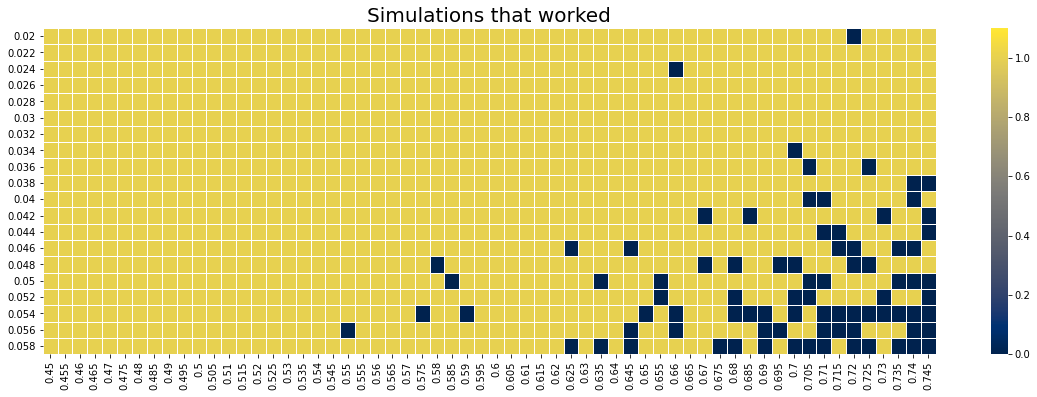

In [13]:
import seaborn as sns
plt.figure(figsize=(20,6))
plt.title('Simulations that worked',fontdict={'fontsize':20})

ax=sns.heatmap(paramset.T,cmap='cividis',linewidths=.8,xticklabels=G_LIST,yticklabels=N_LIST,vmax=1.1)


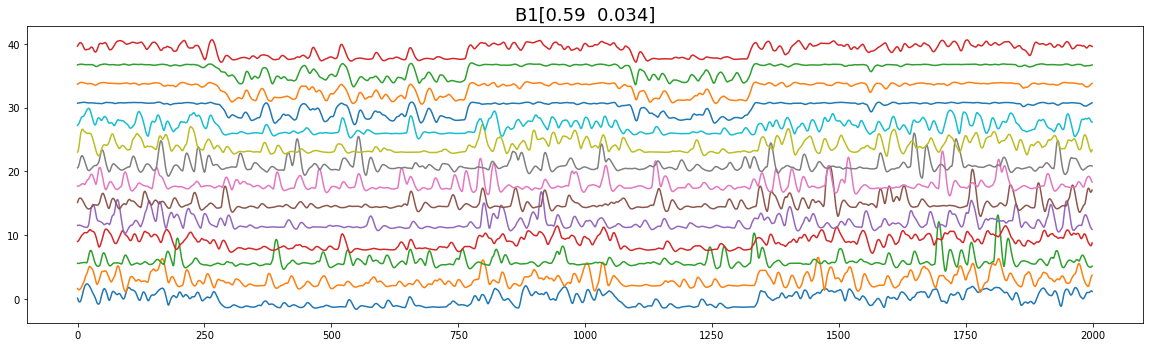

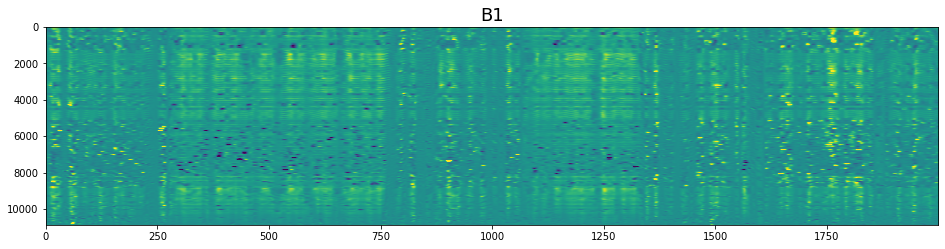

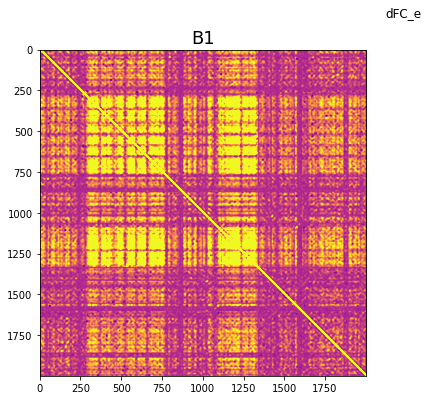

In [14]:
G=0.59
N=0.034
k=(np.where((param[:,0]==G)&(param[:,1]==N)))[0][0]
B1=B[:,:,k]
plt.figure(figsize=(20,12))
plt.subplot(211)
plt.title('B1'+np.str(param[k,:]),fontsize=18)
for i in range(14):
    plt.plot(stats.zscore(B1[:,i])+3*i)
    
    
plt.figure(figsize=(16,8))
plt.subplot(211)
plt.title('B1',fontsize=18)
plt.imshow(go_edge(B1).T,vmin=-2.5,vmax=2.5,aspect='auto')

plt.figure(figsize=(14,6))
plt.suptitle('dFC_e')
plt.subplot(121)
plt.title('B1',fontsize=18)
plt.imshow(np.corrcoef(go_edge(B1)),cmap='plasma',vmax=0.2)


In [15]:
regions.iloc[functional_hub(B1),:]

,regions,module
25,Right Temporal association areas,DMN
94,"Left Agranular insular area, dorsal part",LCN
99,Left Temporal association areas,DMN
11,Right Anteromedial visual area,DMN
26,Right Ectorhinal area,DMN


In [16]:
for k in range(param.shape[0]):
    if not ((param[k,:] == Measures.iloc[:,-2:]).all(axis=1)).any():
        MG=edges_var(B[:,:,k])
        #MS=simpsonbis(B[:,:,k])
        MM=Giom_mean(B[:,:,k])
        add=pd.DataFrame([0,MG,MM,param[k,:][0],param[k,:][1]]).T
        add.columns=Measures.columns
        Measures=Measures.append(add,ignore_index=True)

KeyboardInterrupt: 

In [ ]:
#Measures.to_csv('Measures_2ndbatch.csv',index=False)

In [ ]:
annotations = np.array([Measures.G,Measures.N]).T
MEASUREM=Measures['Gio mean']
MEASURES=Measures['Simpson indice']
MEASUREG=Measures['Gradient']

plt.figure(figsize=(15,15))
plt.scatter(MEASUREM,MEASURES)
plt.xlabel('Gio mean')
plt.ylabel('Simpson indice')
for i, label in enumerate(annotations):
    plt.annotate(label, (MEASUREM[i], MEASURES[i]))
plt.show()

In [19]:
hub_number=12
m=B.shape[2]
q=Bemp.shape[0]
Common_hubs=np.zeros((m,q))
Bsimbis=np.delete(B,remove_roi,axis=1)

for k in range(m):
    inter=np.zeros(q)
    for i in range(q):
        hubs=common_hubs(Bemp[i,:,:],Bsimbis[:,:,k],n=hub_number)
        inter[i]=len(hubs)
    Common_hubs[k,:]=inter

[Text(0.5, 51.0, 'Parameter couple'), Text(159.0, 0.5, 'Empirical dataset')]

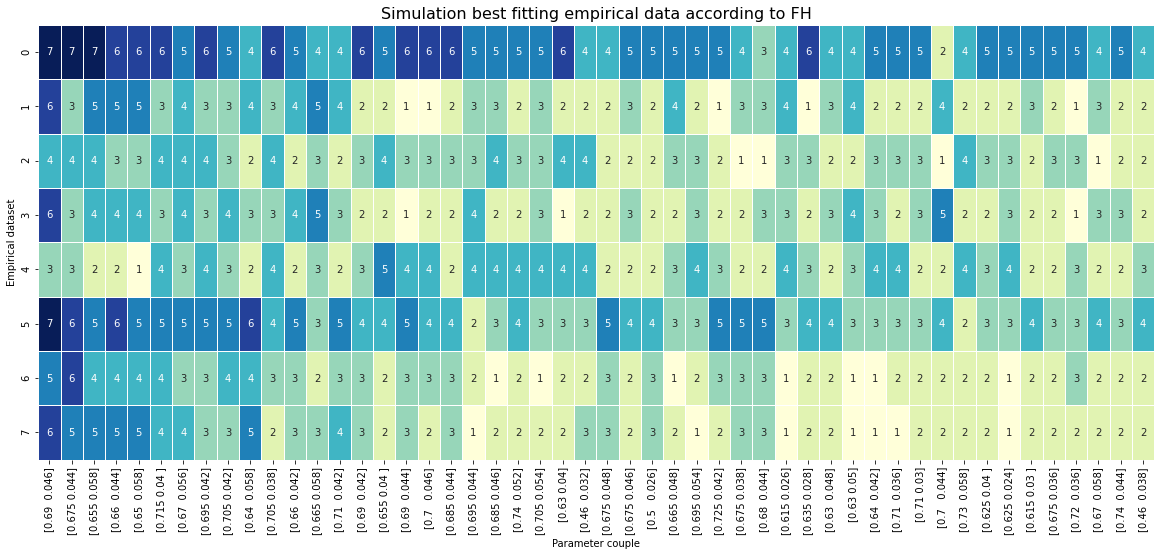

In [21]:
Count=np.sum(Common_hubs,axis=1)
sortedsim=(np.flip(np.unravel_index(np.argsort(Count, axis=None), Count.shape)[0]))
num_sim=50

to_plot=Common_hubs[sortedsim[:num_sim],:]
plt.figure(figsize=(20,8))
plt.title('Simulation best fitting empirical data according to FH',fontdict={'fontsize':16})
ax = sns.heatmap(to_plot.T, cmap='YlGnBu',annot=True,xticklabels=param[sortedsim[:num_sim],:],cbar=False,linewidths=.8)
ax.set(xlabel="Parameter couple", ylabel = "Empirical dataset")

In [20]:
regions["remove_ROI"]=np.isin(regions.index.tolist(),remove_roi)

In [80]:
regions_filt=regions[regions.remove_ROI==False].reset_index(drop=True)
print(regions_filt.groupby('module').count())
print(regions.groupby('module').count())

        regions  remove_ROI
module                     
BF            6           6
DMN          30          30
Hc           18          18
LCN          20          20
Other         6           6
Th           10          10
VM           18          18
        regions  remove_ROI
module                     
BF            8           8
DMN          30          30
Hc           24          24
LCN          20          20
Other        38          38
Th           10          10
VM           18          18


In [186]:
Bempmod=np.zeros((Bemp.shape[0],Bemp.shape[1],len(np.unique(regions_filt.module))))
Bmod=np.zeros((B.shape[0],B.shape[2],len(np.unique(regions_filt.module))))
m=0
for k in np.unique(regions_filt.module):
    p=regions_filt[regions_filt['regions'].isin(Modules[k])].index.tolist()
    Bempmod[:,:,m]=np.mean(Bemp[:,:,p],axis=2)
    Bmod[:,:,m]=np.mean(B[:,p,:],axis=1)
    m+=1

In [188]:
print(Bmod.shape)
print(Bempmod.shape)


(2000, 1112, 7)
(8, 2000, 7)


In [170]:
print(BempTh.shape)
print(BTh.shape)

(8, 2000)
(2000, 1112)


In [55]:
m=B.shape[2]
q=Bemp.shape[0]
PP=np.zeros((m,q))
Bsimbis=np.delete(B,remove_roi,axis=1)

for k in range(m):
    inter=np.zeros(q)
    for i in range(q):
        pp=predictive_power(Bemp[i,:,:],Bsimbis[:,:,k])
        inter[i]=pp[0]
    PP[k,:]=inter
Bestpp=np.max(PP,axis=1)

KeyError: 0

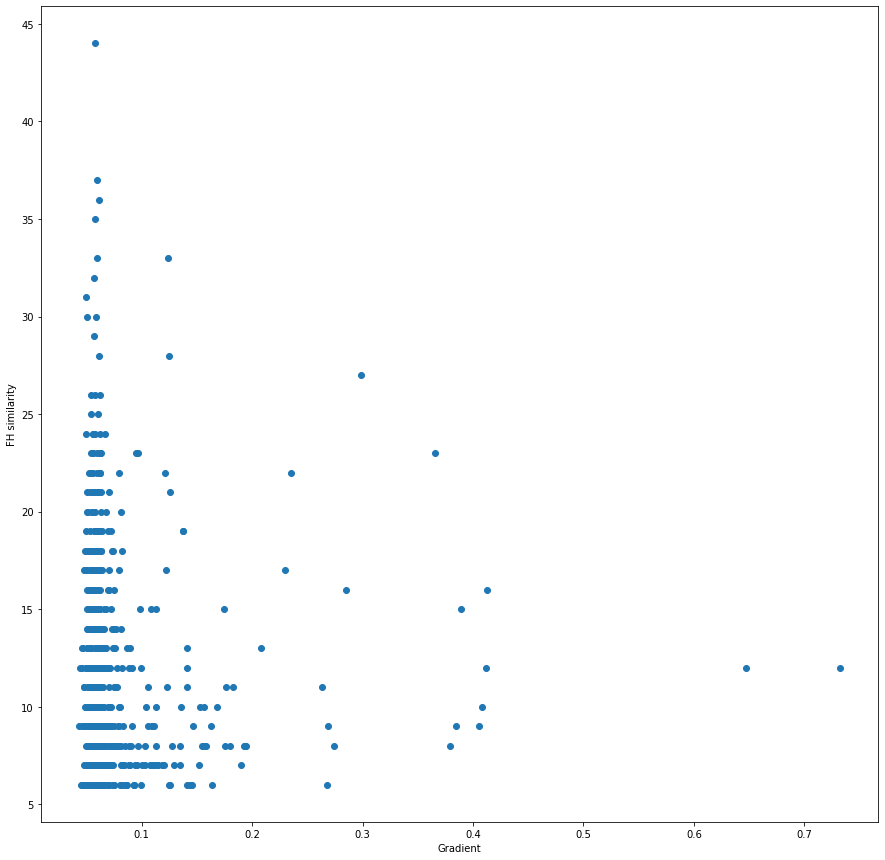

In [25]:
k=5
annotations = param[Count>k]

plt.figure(figsize=(15,15))
plt.scatter(MEASUREM[Count>k],Count[Count>k])
plt.xlabel('Gradient')
plt.ylabel('FH similarity')
for i, label in enumerate(annotations):
    plt.annotate(label, (MEASUREM[Count>k][i], Count[Count>k][i]))
plt.show()

<ipython-input-142-0241ed01d6d9>:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  annotations = np.array([Measures.G,Measures.N]).T[indices]
<ipython-input-142-0241ed01d6d9>:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(np.array(MEASUREG)[indices],np.array(Bestpp)[indices])
<ipython-input-142-0241ed01d6d9>:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which 

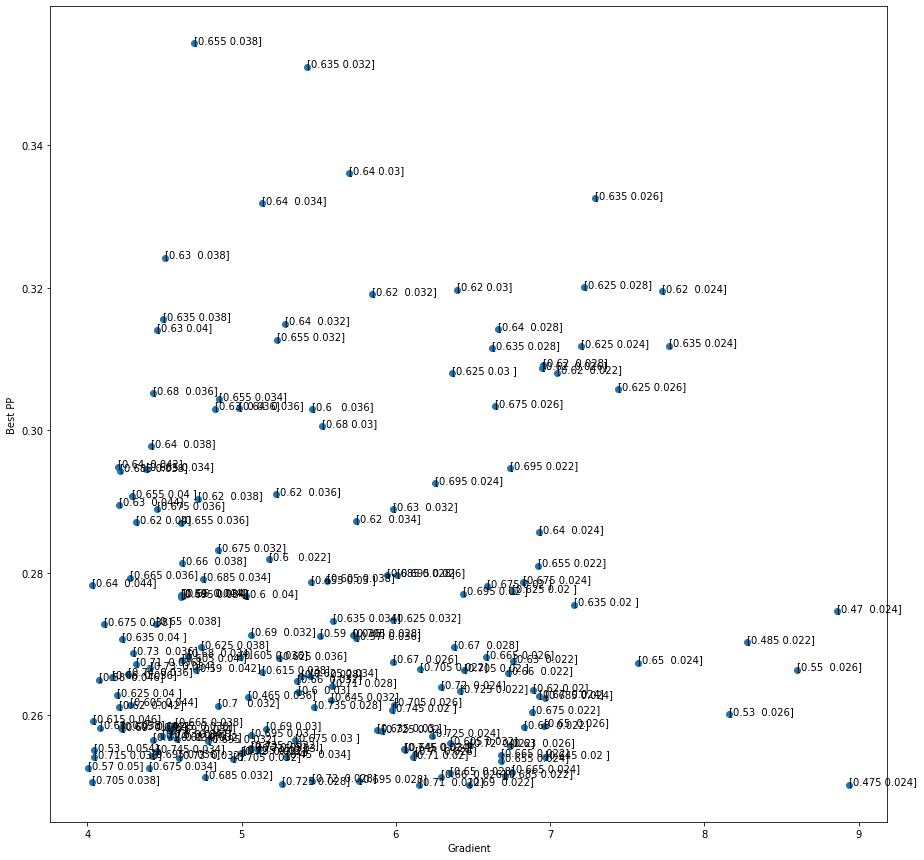

In [142]:
indices=[(MEASUREG>4)&(Bestpp>0.25)]
annotations = np.array([Measures.G,Measures.N]).T[indices]

plt.figure(figsize=(15,15))
plt.scatter(np.array(MEASUREG)[indices],np.array(Bestpp)[indices])
plt.xlabel('Gradient')
plt.ylabel('Best PP')
for i, label in enumerate(annotations):
    plt.annotate(label, (np.array(MEASUREG)[indices][i], np.array(Bestpp)[indices][i]))
plt.show()

In [67]:
MEASUREG.shape

(1078,)

In [66]:
G_LIST     = list(np.round(np.arange(0.45,0.75,0.005),decimals=3))
N_LIST     = list(np.round(np.arange(0.02,0.06,0.002),decimals=3))
mG=stats.zscore(MEASUREG)
toplot=np.zeros((len(G_LIST),len(N_LIST)))
k,j=0,0
for kk in G_LIST:
    j=0
    for jj in N_LIST:
        if [kk,jj] in param.tolist():
            m=(np.where((param[:,0]==kk)&(param[:,1]==jj)))[0][0]
            toplot[k,j]=MEASURES[m]+mG[m]
        j+=1
    k+=1

plt.figure(figsize=(18,6))
plt.imshow(toplot.T,aspect='auto',interpolation='nearest',cmap='viridis');
plt.xticks(np.arange(len(G_LIST)),np.around(G_LIST,3),rotation=60,fontsize=12);
plt.yticks(np.arange(len(N_LIST)),np.around(N_LIST,3)[::-1],fontsize=12);plt.title('Variance of the dFC', fontsize=20);
plt.colorbar();plt.xlabel('Global Coupling G',fontsize=16);plt.ylabel('Noise',fontsize=16);
plt.tight_layout()
plt.show()

KeyError: 1097